In [1]:
import sys

sys.path.append("..")


from pyrocell.gp.gpflow.test import TestOsc

(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=14.94501841492048>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=212.0446062169906>)
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=12.115685613473804>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=130.75992255803146>)
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=11.492106355155595>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=124.44537355309991>)
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=7.000007570851572>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=86.35540124376318>)
7.239964458255131
0
detrending
(92, 1)
OU/OUosc


2024-11-24 19:43:27.325975: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


[<tf.Tensor: shape=(), dtype=float64, numpy=-48.21906449915613>, <tf.Tensor: shape=(), dtype=float64, numpy=-48.2190644992305>, <tf.Tensor: shape=(), dtype=float64, numpy=-48.21906449915646>, <tf.Tensor: shape=(), dtype=float64, numpy=-48.219064499155124>, <tf.Tensor: shape=(), dtype=float64, numpy=-48.21906449915565>, <tf.Tensor: shape=(), dtype=float64, numpy=-48.2190644991575>, <tf.Tensor: shape=(), dtype=float64, numpy=-48.21906449915569>, <tf.Tensor: shape=(), dtype=float64, numpy=-48.21906449925474>, <tf.Tensor: shape=(), dtype=float64, numpy=-48.21906449917134>, <tf.Tensor: shape=(), dtype=float64, numpy=-48.21906449916108>]
10
[<tf.Tensor: shape=(), dtype=float64, numpy=-44.4162064704484>, <tf.Tensor: shape=(), dtype=float64, numpy=-44.37560586367157>, <tf.Tensor: shape=(), dtype=float64, numpy=-44.375605863431346>, <tf.Tensor: shape=(), dtype=float64, numpy=-44.37560586597948>, <tf.Tensor: shape=(), dtype=float64, numpy=-44.375605863550604>, <tf.Tensor: shape=(), dtype=float64

2024-11-24 19:43:49.488140: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-11-24 19:43:49.488764: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


[<tf.Tensor: shape=(), dtype=float64, numpy=-43.66955101571243>, <tf.Tensor: shape=(), dtype=float64, numpy=-43.669551015712344>, <tf.Tensor: shape=(), dtype=float64, numpy=-43.66955101571182>, <tf.Tensor: shape=(), dtype=float64, numpy=-43.66955101571226>, <tf.Tensor: shape=(), dtype=float64, numpy=-43.66955101577824>, <tf.Tensor: shape=(), dtype=float64, numpy=-43.66955101571264>, <tf.Tensor: shape=(), dtype=float64, numpy=-43.669551015713104>, <tf.Tensor: shape=(), dtype=float64, numpy=-43.66955101571195>, <tf.Tensor: shape=(), dtype=float64, numpy=-43.669551015712095>, <tf.Tensor: shape=(), dtype=float64, numpy=-43.66955101573623>]
10
[<tf.Tensor: shape=(), dtype=float64, numpy=-32.74329373561545>, <tf.Tensor: shape=(), dtype=float64, numpy=-32.74329373555117>, <tf.Tensor: shape=(), dtype=float64, numpy=-32.743293735545095>, <tf.Tensor: shape=(), dtype=float64, numpy=-32.743293735554545>, <tf.Tensor: shape=(), dtype=float64, numpy=-32.74329373565935>, <tf.Tensor: shape=(), dtype=fl

2024-11-24 19:43:56.317263: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


[<tf.Tensor: shape=(), dtype=float64, numpy=-56.984165718406565>, <tf.Tensor: shape=(), dtype=float64, numpy=-56.98416571841992>, <tf.Tensor: shape=(), dtype=float64, numpy=-56.98416571843814>, <tf.Tensor: shape=(), dtype=float64, numpy=-56.98416571840649>, <tf.Tensor: shape=(), dtype=float64, numpy=-56.984165718480696>, <tf.Tensor: shape=(), dtype=float64, numpy=-56.98416571841144>, <tf.Tensor: shape=(), dtype=float64, numpy=-56.98416571936728>, <tf.Tensor: shape=(), dtype=float64, numpy=-56.984165718406146>, <tf.Tensor: shape=(), dtype=float64, numpy=-56.98416571864833>, <tf.Tensor: shape=(), dtype=float64, numpy=-56.98416571841697>]
10
[<tf.Tensor: shape=(), dtype=float64, numpy=-46.42199283855812>, <tf.Tensor: shape=(), dtype=float64, numpy=-46.42199283851025>, <tf.Tensor: shape=(), dtype=float64, numpy=-46.421992838662874>, <tf.Tensor: shape=(), dtype=float64, numpy=-46.421992838705975>, <tf.Tensor: shape=(), dtype=float64, numpy=-46.421992838519124>, <tf.Tensor: shape=(), dtype=f

2024-11-24 19:44:02.755480: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-11-24 19:44:02.756464: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


[<tf.Tensor: shape=(), dtype=float64, numpy=-54.36566482199461>, <tf.Tensor: shape=(), dtype=float64, numpy=-54.36566482200648>, <tf.Tensor: shape=(), dtype=float64, numpy=-54.36566482199381>, <tf.Tensor: shape=(), dtype=float64, numpy=-54.3656648219906>, <tf.Tensor: shape=(), dtype=float64, numpy=-54.36566482230742>, <tf.Tensor: shape=(), dtype=float64, numpy=-54.365664822004454>, <tf.Tensor: shape=(), dtype=float64, numpy=-54.36566482199379>, <tf.Tensor: shape=(), dtype=float64, numpy=-54.3656648219908>, <tf.Tensor: shape=(), dtype=float64, numpy=-54.36566482219527>, <tf.Tensor: shape=(), dtype=float64, numpy=-54.36566482201357>]
10
[<tf.Tensor: shape=(), dtype=float64, numpy=-53.72915224709667>, <tf.Tensor: shape=(), dtype=float64, numpy=-53.72915227708451>, <tf.Tensor: shape=(), dtype=float64, numpy=-53.72915224790473>, <tf.Tensor: shape=(), dtype=float64, numpy=-53.72915224709921>, <tf.Tensor: shape=(), dtype=float64, numpy=-53.72915224709568>, <tf.Tensor: shape=(), dtype=float64,

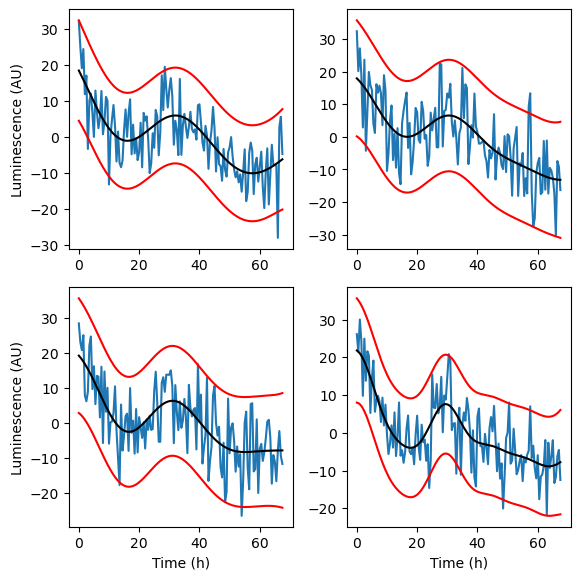

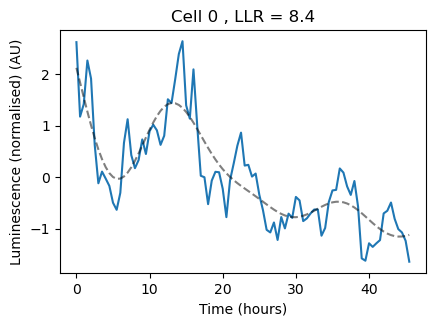

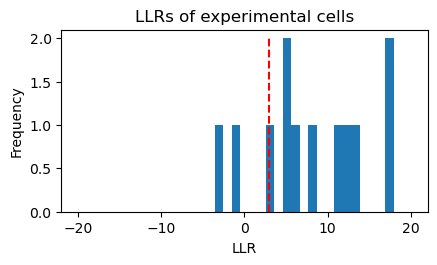

In [2]:
TestOsc()